In [7]:
import numpy as np
import os
from PIL import Image
import os
import xml.etree.ElementTree as ET
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [2]:
# function to load images from specified folder path
def load_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        if os.path.isfile(img_path):
            try:
                img = Image.open(img_path)
                images.append(img)
            except Exception as e:
                print(f"Error loading image: {img_path} - {e}")
    return images

Error loading image: ./images/2.xml - cannot identify image file './images/2.xml'
Error loading image: ./images/1.xml - cannot identify image file './images/1.xml'


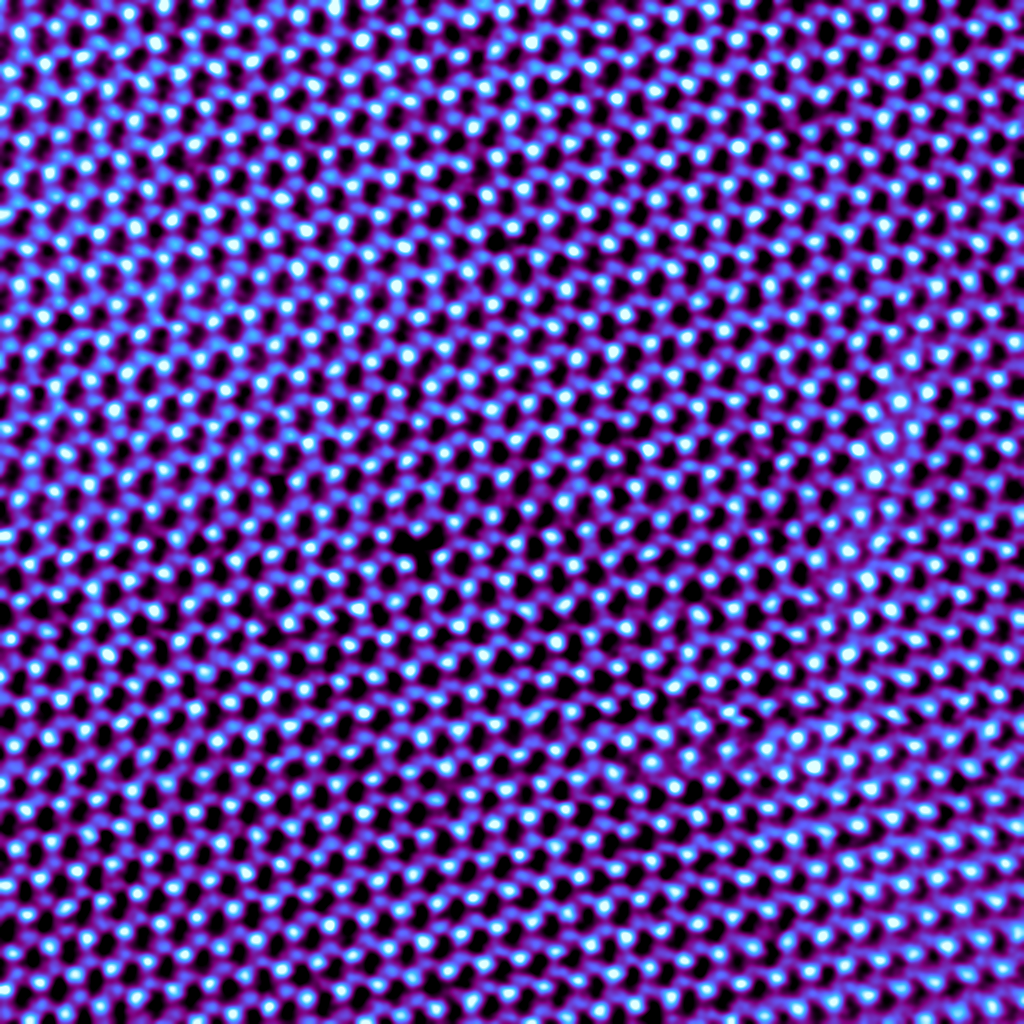

In [3]:
# Specify the folder path containing the images
folder_path = './images'

# Load images from the folder
images = load_images_from_folder(folder_path)

# Display the first image
if len(images) > 0:
    images[0].show()
else:
    print("No images found in the folder.")

In [4]:
# Finds class and boundary box data in .xml files 
def parse_xml_label(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    # Extract image size (optional)
    size_elem = root.find('size')
    width = int(size_elem.find('width').text)
    height = int(size_elem.find('height').text)
    depth = int(size_elem.find('depth').text)
    
    # Extract object annotations
    annotations = []
    for obj_elem in root.findall('object'):
        name = obj_elem.find('name').text
        bbox_elem = obj_elem.find('bndbox')
        xmin = int(bbox_elem.find('xmin').text)
        ymin = int(bbox_elem.find('ymin').text)
        xmax = int(bbox_elem.find('xmax').text)
        ymax = int(bbox_elem.find('ymax').text)
        annotations.append({
            'name': name,
            'xmin': xmin,
            'ymin': ymin,
            'xmax': xmax,
            'ymax': ymax
        })
    
    return width, height, depth, annotations

In [5]:
# Specify the directory path containing the XML labels
labels_dir = './images'

# Load .xml labels for all files in the directory
# This is a dictionary object
labels = {}
for filename in os.listdir(labels_dir):
    if filename.endswith('.xml'):
        xml_path = os.path.join(labels_dir, filename)
        width, height, depth, annotations = parse_xml_label(xml_path)
        labels[filename] = {
            'width': width,
            'height': height,
            'depth': depth,
            'annotations': annotations
        }

In [6]:
# This is a class for the data loader for images and labels
class YourDataset(Dataset):
    def __init__(self, images, labels, target_size):
        self.images = images
        self.labels = labels
        self.target_size = target_size
        self.transform = transforms.Compose([
            transforms.Resize(target_size),  # resize the image before converting to a tensor
            transforms.ToTensor(),  # then convert to a tensor
        ])
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = self.images[index]
        # Here the index is passed to a list for images but the labels are a dict so the index is 
        #concverted to a key
        label_index = index + 1
        key = f"{label_index}.xml"  
        label = labels[key]
    
        # Transforms the image into appropriate sized tensor
        image = self.transform(image)
    
        # Convert the annotations to tensors
        annotations = label.get('annotations', [])
        annotation_tensors = []
        # This dictionary is for classification of the defects
        class_to_label = {'Point': 0, 'Void': 1, 'Point Defect': 0}

        for annotation in annotations:
            class_label = class_to_label[annotation.get('name')]
            xmin = annotation.get('xmin', 0)
            ymin = annotation.get('ymin', 0)
            xmax = annotation.get('xmax', 0)
            ymax = annotation.get('ymax', 0)
            
            annotation_tensor = torch.tensor([class_label, xmin, ymin, xmax, ymax])
            annotation_tensors.append(annotation_tensor)
        
        # Pad the annotation tensors to a fixed length
        # if images have different number of annotations it causes shape error
        max_annotations = 15
        while len(annotation_tensors) < max_annotations:
            # Append padding annotation
            pad_tensor = torch.tensor([-1, -1, -1, -1, -1])  # Padding value
            annotation_tensors.append(pad_tensor)
        
            
        return image, annotation_tensors

In [8]:
# Create an instance of your Dataset
dataset = YourDataset(images, labels, (256, 256))

# Check the length of your dataset
print(f"Dataset length: {len(dataset)}")  # should be 2

# Load the data from your Dataset

data_loader = DataLoader(dataset, batch_size=1)  # batch_size can be adjusted based on your requirement

# Get an iterator from the DataLoader
data_iter = iter(data_loader)

# Get the first item
first_item = next(data_iter)

# first_item now contains the first batch of data from your data_loader.
# It's a list where the first element is the image tensor and the second element is the annotations tensor.

# If you want to access the first image and its corresponding annotations, you can do:
first_image, first_annotations = first_item

print("First Image shape: ", first_image.shape)

Dataset length: 2
First Image shape:  torch.Size([1, 3, 256, 256])


In [9]:
first_image, first_annotations

(tensor([[[[0.3098, 0.4000, 0.3137,  ..., 0.4549, 0.4196, 0.4039],
           [0.3373, 0.4196, 0.3255,  ..., 0.4510, 0.4118, 0.4039],
           [0.3882, 0.4431, 0.3569,  ..., 0.4392, 0.4314, 0.4431],
           ...,
           [0.3961, 0.3686, 0.4039,  ..., 0.2235, 0.3490, 0.4275],
           [0.4353, 0.4157, 0.4275,  ..., 0.2980, 0.4275, 0.4667],
           [0.4784, 0.4353, 0.3020,  ..., 0.4196, 0.4588, 0.4431]],
 
          [[0.6588, 0.2863, 0.0157,  ..., 0.1137, 0.2471, 0.2902],
           [0.5020, 0.2235, 0.0118,  ..., 0.1333, 0.2627, 0.2980],
           [0.3451, 0.1608, 0.0118,  ..., 0.1765, 0.2039, 0.1647],
           ...,
           [0.3098, 0.3961, 0.2980,  ..., 0.0000, 0.0000, 0.0000],
           [0.2000, 0.2549, 0.1647,  ..., 0.0000, 0.0157, 0.0353],
           [0.0471, 0.0431, 0.0118,  ..., 0.0118, 0.1059, 0.1765]],
 
          [[1.0000, 0.8196, 0.3412,  ..., 0.6471, 0.8275, 0.8863],
           [0.9922, 0.7725, 0.3490,  ..., 0.6706, 0.8471, 0.8941],
           [0.9333, 0.70